In [22]:
import tensorflow as tf
import numpy as np
from tensorflow.python.framework import ops

ops.reset_default_graph()

# encoding
# char_arr => [S,E,P,a,b,...]
char_arr = [c for c in 'SEPabcdefghijklmnopqrstuvwxyz단어나무놀이소녀연습사랑'] 
num_dic = {n: i for i, n in enumerate(char_arr)}
dic_len = len(num_dic)
print(dic_len)

# seq2seq 번역망
seq_data = [["word", "단어"], ["wood", "나무"],
           ["game", "놀이"], ["girl", "소녀"],
           ["test", "연습"], ["love", "사랑"]]

def make_batch(seq_data):
    input_batch = []
    output_batch = []
    target_batch = []
    for seq in seq_data:
        input = [num_dic[n] for n in seq[0]]
        # 첫번째 입력되는 데이터는 "word"이 학습된 smoking gun
        output = [num_dic[n] for n in ("S" + seq[1])] # 훈련된 특징값 시작
        target = [num_dic[n] for n in (seq[1] + "E")] # 끝을 확인
        
        # identity matrix 단위행렬 => one-hot-encoding
        # 1, 000000...(42자리까지)
        # 0, 1, 00000...
        # 0, 0, 1, 000000...
        input_batch.append(np.eye(dic_len)[input]) # 25, 17 # 2차원배열 # 4x42
        output_batch.append(np.eye(dic_len)[output]) # 2x42
        target_batch.append(target)
        
    return input_batch, output_batch, target_batch
    
learning_rate = 0.01
n_hidden = 128 # neurons 출력이 128차
total_epoch = 100
n_class = n_input = dic_len

# encoder, decoder용 데이터 주입변수
enc_input = tf.placeholder(tf.float32, [None, None, n_input])
dec_input = tf.placeholder(tf.float32, [None, None, n_input])
targets = tf.placeholder(tf.int64, [None, None])

with tf.variable_scope("encode"):
    # FFNN 한개 입력 -> 가중치 -> 출력(n_hidden)
    enc_cell = tf.nn.rnn_cell.BasicRNNCell(n_hidden) # 입력 42x128
    # 과적합을 방지하기 위해서 계산회로를 생략 - random하게 생략
    enc_cell = tf.nn.rnn_cell.DropoutWrapper(enc_cell, output_keep_prob=0.5, seed=100)
    # cell이 4개, cell당 42개의 데이터가 입력
    outputs, enc_states = tf.nn.dynamic_rnn(enc_cell, enc_input, dtype=tf.float32)
    
with tf.variable_scope("decode"):
    dec_cell = tf.nn.rnn_cell.BasicRNNCell(n_hidden) # 128
    dec_cell = tf.nn.rnn_cell.DropoutWrapper(dec_cell, output_keep_prob=0.5, seed=100)
    # cell이 2개, 2x42
    # initial_state
    #   : 앞의 encoder망에서 출력된 states값=마지막 cell의 출력값
    #   : 앞의 데이터를 다 고려한 특징
    #   : 두 개의 망을 연결
    outputs, dec_states = tf.nn.dynamic_rnn(dec_cell, dec_input, initial_state=enc_states, dtype=tf.float32)
    
# 6 x 3 x 128 x 41
# 6 x 3 x 1
model = tf.layers.dense(outputs, n_class, activation=None)
cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model, labels=targets))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

41


In [23]:
input_batch, output_batch, target_batch = make_batch(seq_data)
for epoch in range(total_epoch): # total_epoch=100
    _, loss = sess.run([optimizer, cost], feed_dict={enc_input: input_batch, dec_input: output_batch, targets: target_batch})
    print("Epoch:", "%04d" % (epoch+1), "cost =", "{:.6f}".format(loss))

Epoch: 0001 cost = 3.711169
Epoch: 0002 cost = 2.741933
Epoch: 0003 cost = 1.536085
Epoch: 0004 cost = 1.114448
Epoch: 0005 cost = 0.546320
Epoch: 0006 cost = 0.405680
Epoch: 0007 cost = 0.332284
Epoch: 0008 cost = 0.181093
Epoch: 0009 cost = 0.118089
Epoch: 0010 cost = 0.080526
Epoch: 0011 cost = 0.054024
Epoch: 0012 cost = 0.119040
Epoch: 0013 cost = 0.018658
Epoch: 0014 cost = 0.099673
Epoch: 0015 cost = 0.024198
Epoch: 0016 cost = 0.026385
Epoch: 0017 cost = 0.028144
Epoch: 0018 cost = 0.013008
Epoch: 0019 cost = 0.005076
Epoch: 0020 cost = 0.003698
Epoch: 0021 cost = 0.004819
Epoch: 0022 cost = 0.002408
Epoch: 0023 cost = 0.039711
Epoch: 0024 cost = 0.005185
Epoch: 0025 cost = 0.004118
Epoch: 0026 cost = 0.003496
Epoch: 0027 cost = 0.006922
Epoch: 0028 cost = 0.003945
Epoch: 0029 cost = 0.002639
Epoch: 0030 cost = 0.001785
Epoch: 0031 cost = 0.001418
Epoch: 0032 cost = 0.002234
Epoch: 0033 cost = 0.003784
Epoch: 0034 cost = 0.003025
Epoch: 0035 cost = 0.002241
Epoch: 0036 cost = 0

In [24]:
def translate(word):
    # 모델의 자리수는 일치시켜야 한다.
    seq_data = [word, "P" * len(word)] # PPPP
    input_batch, output_batch, target_batch = make_batch([seq_data])
    # 1 x 4 x 41
    prediction = tf.argmax(model, 2) # '면, 행, 열'중에 열 중심 41개 중에 max값
    result = sess.run(prediction, feed_dict={enc_input: input_batch, dec_input: output_batch,
                                            targets: target_batch})

    decoded = [char_arr[i] for i in result[0]]
    end = decoded.index("E")
    translated = "".join(decoded[:end])
    
    return translated

print("word ->", translate("word"))

word -> 단어


In [25]:
# OCR : Kakao API

In [87]:
import cv2
import json
import requests
import sys
LIMIT_PX = 1024
LIMIT_BYTE = 1024 * 1024
LIMIT_BOX = 40

In [88]:
# api 사용전에 이미지가 resize된 경우, recognize시 resize된 결과를 사용해야함.
def kakao_ocr_resize(image_path: str):
    image = cv2.imread(image_path)
    height, width, _ = image.shape
    if LIMIT_PX < height or LIMIT_PX < width:
        ratio = float(LIMIT_PX) / max(height, width)
        image = cv2.resize(image, None, fx=ratio, fy=ratio)
        height, width, _ = height, width, _ = image.shape
        image_path = "{}_resized.jpg".format("2")
        cv2.imwrite(image_path, image)
        return image_path
    return None

In [89]:
def kakao_ocr_detect(image_path: str, appkey: str):
    API_URL = "https://kapi.kakao.com/v1/vision/text/detect"
    headers = {"Authorization" : "KakaoAK {}".format(appkey)}
    image = cv2.imread(image_path)
    jpeg_image = cv2.imencode(".jpg", image)[1]
    data = jpeg_image.tobytes()
    
    # 네트워크 -> 데이터를 serial형식으로 넘겨야함
    resp = requests.post(API_URL, headers, files={"file" : data})
    print(resp)

    return resp

In [90]:
def kakao_ocr_recognize(image_path: str, boxes: list, appkey: str):
    API_URL = "https://kapi.kakao.com/v1/vision/text/recognize"
    headers = {"Authorization" : "KakaoAK {}".format(appkey)}
    image = cv2.imread(image_path)
    jpeg_image = cv2.imencode(".jpg", image)[1]
    data = jpeg_image.tobytes()
    return requests.post(API_URL, headers,
                         files={"file" : data},
                         data={"boxes":json.dumps(boxes)})

In [91]:
def main():
    #image_path, appkey = sys.argv[0], sys.argv[0]
    image_path, appkey = "3.jpg", "0f7afc62141be4a96389d07160d79381"
    resize_impath = kakao_ocr_resize(image_path)
    output = kakao_ocr_detect(image_path, appkey).json()
    print(output)
    boxes = output["result"]["boxes"]
    boxes = boxes[:min(len(boxes), LIMIT_BOX)]
    output = kakao_ocr_recognize(image_path, boxes, appkey).json()
    
output = main()
output["result"] # 글씨로 변환된 결과

<Response [400]>
{'msg': 'unknown multipart entry. name=Authorization', 'code': -2}


KeyError: 'result'

In [4]:
import cv2
import numpy as np

history = 30

# cap = cv2.VideoCapture(0) : 0번 device로부터 카메라 영상을 받아들인다.
cap = cv2.VideoCapture("corrupted_video.mp4")

fgbg = cv2.createBackgroundSubtractorMOG2() # Background Filter

# isOpened() == False : 파일이나 장치가 존재하지 않는다.
if(cap.isOpened() == False) :
    print("에러 발생")

while(cap.isOpened()):
    ret, frame = cap.read() # 1개의 frame => 동영상은 ntsc방식 29.7fps
    if ret == True:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        fgmask = fgbg.apply(gray, learningRate=1.0/history)
        cv2.imshow("Frame", fgmask) # 이미지 출력
        if cv2.waitKey(25) & 0xFF == ord("q"): # ord("q") : q에 대한 ascii코드값(=0xFF)
            break
    else:
        break
        
cap.release()
cv2.destroyAllWindows()

In [5]:
# 동영상 저장
import cv2
import numpy as np # computer vision 처리 -> 사운드 불가

cap = cv2.VideoCapture("corrupted_video.mp4")
fourcc = cv2.VideoWriter_fourcc(*"XVID") # codec
out = cv2.VideoWriter("output.avi", fourcc, 20.0, (640,480))

while(cap.isOpened()) :
    ret, frame = cap.read()
    if ret == True:
        frame = cv2.flip(frame, 0)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        out.write(frame)
        cv2.imshow("frame", frame)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        break
        
cap.release()
out.release()
cv2.destroyAllWindows()

In [ ]:
# Denosing Encoder
#  - 원본, noise가 있는 학습데이터
#  - 학습은 noise가 있는 학습데이터 => 가중치
#  - autoencoder는 denoising을 한다.

In [1]:
# AE(AutoEncoder)
%matplotlib inline
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def vis(images, save_name):
    dim = images.shape[0]
    n_image_rows = int(np.ceil(np.sqrt(dim)))
    n_image_cols = int(np.ceil(dim * 1.0/n_image_rows))
    gs = gridspec.GridSpec(n_image_rows, n_image_cols, top=1., bottom=0., right=1., left=0., hspace=0., wspace=0.)
    for g, count in zip(gs, range(int(dim))):
        ax = plt.subplot(g)
        ax.imshow(images[count, :].reshape((28,28)))
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.savefig(save_name + "_vis.png")
    plt.show()
    
mnist_width = 28
n_visible = mnist_width * mnist_width
n_hidden = 500

In [2]:
corruption_level = 0.3

# n_visible=784
X = tf.placeholder("float", [None, n_visible], name="X")
mask = tf.placeholder("float", [None, n_visible], name="mask")
W_init_max = 4 * np.sqrt(6. / (n_visible + n_hidden))
# 균등분포에서 데이터를 생성(가중치 초기화)
W_init = tf.random_uniform(shape=[n_visible, n_hidden], minval=-W_init_max, maxval=W_init_max)
W = tf.Variable(W_init, name="W")
b = tf.Variable(tf.zeros([n_hidden]), name="b")

In [3]:
W_prime = tf.transpose(W) # 자기자신의 전치
b_prime = tf.Variable(tf.zeros([n_visible]), name="b_prime")
def model(X, mask, W, b, W_prime, b_prime):
    tilde_X = mask * X # 행렬 요소곱
    Y = tf.nn.sigmoid(tf.matmul(tilde_X, W) + b)
    Z = tf.nn.sigmoid(tf.matmul(Y, W_prime) + b_prime)
    return Z

Z = model(X, mask, W, b, W_prime, b_prime)
# 가중치에 이미지의 특성이 추출된다.

In [4]:
# 원본데이터 == 예측데이터(자기자신)
# 비지도학습 : 데이터의 특징 : PCA 데이터 재해석(직교하는 축으로)
# AutoEncoder는 input:자기자신 == output:자기자신
# noise : 군데군데 구멍남 : 그런데도 원본의 특징을 추출
cost = tf.reduce_sum(tf.pow(X - Z, 2))
train_op = tf.train.GradientDescentOptimizer(0.02).minimize(cost)
predict_op = Z

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


0 113341.305
1 93598.15
2 88983.35
3 80137.875
4 78116.625
5 74565.37
6 73064.68
7 71201.84
8 70051.37
9 69171.72
10 67511.45
11 66809.27
12 66884.7
13 65298.99
14 64052.32
15 64538.39
16 63327.258
17 62936.176
18 63082.96
19 62194.414
20 62792.88
21 63012.223
22 61341.19
23 61868.184
24 61421.555
25 61498.305
26 60642.273
27 61571.562
28 60877.453
29 61104.016
30 60866.086
31 61390.867
32 60311.94
33 60099.65
34 60148.527
35 61302.055
36 60065.35
37 59475.395
38 58891.812
39 59799.41
40 59643.82
41 59993.1
42 59378.62
43 59821.03
44 59350.92
45 59279.13
46 58510.61
47 58814.57
48 59579.43
49 58759.26
50 58595.9
51 59623.06
52 58647.637
53 58386.65
54 59817.88
55 58224.453
56 57863.11
57 59007.004
58 58602.28
59 59220.938
60 57603.98
61 58179.363
62 59110.62
63 57746.65
64 58190.875
65 58460.46
66 58402.273
67 57089.297
68 58382.16
69 58147.227
70 57065.008
71 57855.984
72 57364.53
73 57918.938
74 57396.777
75 56727.664
76 57454.117
77 57696.906
78 57644.984
79 56922.676
80 57002.906
8

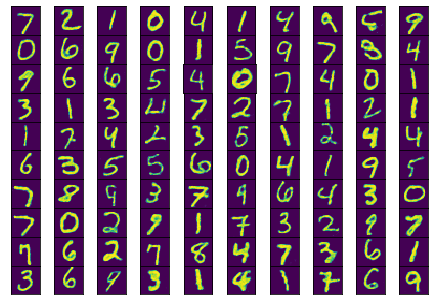

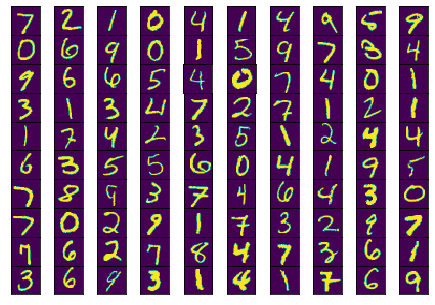

In [5]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for i in range(100):
        for start, end in zip(range(0, len(trX), 128), range(128, len(trX)+1, 128)):
            input_ = trX[start:end]
            mask_np = np.random.binomial(1, 1-corruption_level, input_.shape)
            sess.run(train_op, feed_dict={X:input_, mask: mask_np})
        mask_np = np.random.binomial(1, 1-corruption_level, teX.shape)
        
        print(i, sess.run(cost, feed_dict={X:teX, mask:mask_np}))
        
    mask_np = np.random.binomial(1, 1-corruption_level, teX[:100].shape)
    predicted_imgs = sess.run(predict_op, feed_dict={X:teX[:100], mask:mask_np})
    input_imgs = teX[:100]
    
vis(predicted_imgs, "pred") # 예측된 이미지
print("******************************************")
vis(input_imgs, "in") # 입력 이미지

In [24]:
# 판별모델(Discrimitive Model)
# Variational autoencoder(VAE)
# generative model 생성모델 => 확률    평균 + 분산 = 분포
# 잠재변수(latent variables) : 키, 남자 => 특징 + 노이즈
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np

ops.reset_default_graph()
#train, test = tf.keras.datasets.mnist.load_data()
#train_x, train_y = train
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

from functools import partial
n_inputs = 28 * 28 # 784
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs # 입력이 출력으로
learning_rate = 0.001

# scaling없이 초기화
initializer = tf.contrib.layers.variance_scaling_initializer()

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [25]:
# 매개변수 일부를 고정한다.
my_dense_layer = partial(tf.layers.dense, 
                         activation=tf.nn.elu, # Exponential Liniear Unit(-1을 고려한)
                         kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_sigma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_sigma), dtype=tf.float32)

# 평균, 분산 * 노이즈(변동)
# 요소곱
hidden3 = hidden3_mean + hidden3_sigma * noise # 변동 특성
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
# 자기자신값 28 * 28 = 784
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

In [26]:
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits) # 입력값 == 출력값
# 재구축손실
reconstruction_loss = tf.reduce_sum(xentropy)
# epsilon 상수 : 부동소수점을 비교 0.0001 => 차가 0.0001이하이면 같은 것으로 본다.
eps = 1e-10 # epsilon 상수 : 로그의 성질 : 0이면 무한대

# cost function : 
# 지연손실(확률분포 곡선)
latent_loss = 0.5 * tf.reduce_sum( # log likelihood(우도 확률)
    tf.square(hidden3_sigma) + tf.square(hidden3_mean) -1 -tf.log(eps + tf.square(hidden3_sigma)))
loss = reconstruction_loss + latent_loss
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
init = tf.global_variables_initializer()

In [27]:
import sys
n_digits = 60
n_epochs = 50
batch_size = 150
with tf.Session() as sess:
    init.run()
    for epoch in range(0, n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss],
                                                                     feed_dict={X: X_batch})
        print("\r{}".format(epoch),
              "Train total loss:", loss_val,
              "\tReconstruction loss:", reconstruction_loss_val,
              "\tLatent loss:", latent_loss_val)
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})
    
# 가중치를 통과한 데이터(test) : 모델 완성
# PCA처럼 비지도학습의 특성으로 추출된 데이터(분류와 예측0000)

0 Train total loss: 29581.143 	Reconstruction loss: 25172.305 	Latent loss: 4408.8374
1 Train total loss: 28682.41 	Reconstruction loss: 21805.066 	Latent loss: 6877.3433
29% Train total loss: 31852.764 	Reconstruction loss: 25236.973 	Latent loss: 6615.791
39% Train total loss: 32080.682 	Reconstruction loss: 23684.512 	Latent loss: 8396.17
49% Train total loss: 25633.393 	Reconstruction loss: 21450.104 	Latent loss: 4183.2896
59% Train total loss: 22686.94 	Reconstruction loss: 19596.016 	Latent loss: 3090.923
69% Train total loss: 20076.486 	Reconstruction loss: 17156.24 	Latent loss: 2920.2463
79% Train total loss: 18698.17 	Reconstruction loss: 15810.823 	Latent loss: 2887.3467
8 Train total loss: 17406.588 	Reconstruction loss: 14314.652 	Latent loss: 3091.936
99% Train total loss: 16765.137 	Reconstruction loss: 13572.726 	Latent loss: 3192.4102
10% Train total loss: 16621.383 	Reconstruction loss: 13384.223 	Latent loss: 3237.1592
11% Train total loss: 16686.725 	Reconstruction